In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.linalg import solve_toeplitz



ImportError: cannot import name 'hamming' from 'scipy.signal' (/Users/yasantha-mac/projects/IntelliBee/Data-Collecting-Device/Available-Dataset/lib/python3.12/site-packages/scipy/signal/__init__.py)

In [3]:
COLUMNS = ['date','device','hive number','hive humidity','hive temp','weather temp','weather humidity','queen presence']

In [4]:
CURRENT_PATH = os.getcwd()
DATA_DIR = os.path.join(CURRENT_PATH,'Data')
DATA_FILE = os.path.join(DATA_DIR,'All-Data-Updated.csv')
PREPROCESSED_DIR = os.path.join(CURRENT_PATH,'Preprocessed')

In [5]:
df = pd.read_csv(DATA_FILE)
df.describe()

,device,hive number,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,gust speed,...,cloud coverage,rain,lat,long,queen presence,queen acceptance,frames,target,time,queen status
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1271.000000,1275.000000,1275.000000,1271.000000,281.000000,...,1275.000000,1275.0,1.271000e+03,1271.00,1275.000000,1275.000000,1275.00000,1275.000000,1275.000000,1275.000000
mean,1.554510,2.709020,29.009475,44.663890,1009.179169,20.326845,63.501176,1011.370196,3.805452,4.511317,...,27.868235,0.0,3.729000e+01,-121.95,0.876078,1.549020,9.10902,3.396863,0.482972,2.127843
std,0.497215,1.488587,8.172418,18.359731,2.406004,5.587868,16.207222,56.807873,2.311196,3.931787,...,33.641333,0.0,7.108224e-15,0.00,0.329621,0.704151,0.99443,1.586142,0.287396,1.096649
min,1.000000,1.000000,15.500000,7.230000,1003.540000,10.750000,0.000000,0.000000,0.000000,0.450000,...,0.000000,0.0,3.729000e+01,-121.95,0.000000,0.000000,8.00000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,22.455000,32.245000,1007.375000,15.480000,51.000000,1013.000000,2.060000,1.340000,...,0.000000,0.0,3.729000e+01,-121.95,1.000000,1.000000,8.00000,3.000000,0.250000,1.000000
50%,2.000000,3.000000,27.910000,42.180000,1009.170000,19.280000,66.000000,1014.000000,3.600000,2.680000,...,20.000000,0.0,3.729000e+01,-121.95,1.000000,2.000000,10.00000,3.000000,0.500000,3.000000
75%,2.000000,4.000000,33.075000,54.945000,1010.705000,24.850000,78.000000,1016.000000,5.660000,7.600000,...,40.000000,0.0,3.729000e+01,-121.95,1.000000,2.000000,10.00000,5.000000,0.750000,3.000000
max,2.000000,5.000000,55.620000,93.470000,1015.970000,35.430000,88.000000,1021.000000,10.800000,15.430000,...,100.000000,0.0,3.729000e+01,-121.95,1.000000,2.000000,10.00000,5.000000,0.958000,3.000000


In [10]:
Queen_wav_file_path = os.path.join(DATA_DIR,'Bee-Sound-with-Queen.wav')
Without_Queen_file_path = os.path.join(DATA_DIR,'Bee-Sound-without-Queen.wav')

sampling_rate_Queen, data_Queen = wav.read(Queen_wav_file_path)
sampling_rate_without_Queen, data_without_Queen = wav.read(Without_Queen_file_path)

In [13]:
if data_Queen.ndim == 2:
    signal = np.mean(data_Queen, axis=1)

if data_without_Queen.ndim == 2:
    signal_without_Queen = np.mean(data_without_Queen, axis=1)

sampling_rate = sampling_rate_Queen

In [16]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

# Step 3: Framing and Windowing
frame_size = int(0.025 * sampling_rate)  # 25 ms frame
frame_step = int(0.01 * sampling_rate)   # 10 ms step (overlap)
signal_length = len(emphasized_signal)
num_frames = int(np.ceil(float(np.abs(signal_length - frame_size)) / frame_step))

# Pad signal to make sure all frames have equal number of samples
pad_signal_length = num_frames * frame_step + frame_size
z = np.zeros((pad_signal_length - signal_length))
padded_signal = np.append(emphasized_signal, z)

# Split signal into frames
indices = np.tile(np.arange(0, frame_size), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_size, 1)).T
frames = padded_signal[indices.astype(np.int32, copy=False)]

print("Frames shape:", frames.shape)
# Apply a Hamming window using numpy
frames *= np.hamming(frame_size)

# Step 4: LPC Analysis
def autocorrelation(signal, order):
    result = np.correlate(signal, signal, mode='full')
    return result[len(result)//2:len(result)//2 + order + 1]

def lpc(signal, order):
    R = autocorrelation(signal, order)
    R_matrix = solve_toeplitz((R[:-1], R[:-1]), R[1:])
    return np.concatenate(([1], -R_matrix))

lpc_order = 12
lpc_coefficients = []

for frame in frames:
    coeffs = lpc(frame, lpc_order)
    lpc_coefficients.append(coeffs)

lpc_coefficients = np.array(lpc_coefficients)

# Step 5: Output LPC coefficients for analysis
print("LPC coefficients shape:", lpc_coefficients.shape)

Frames shape: (3886, 1102)
LPC coefficients shape: (3886, 13)


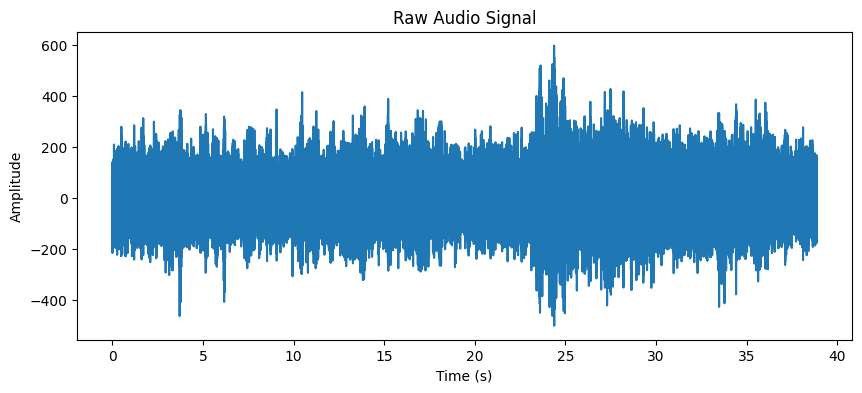

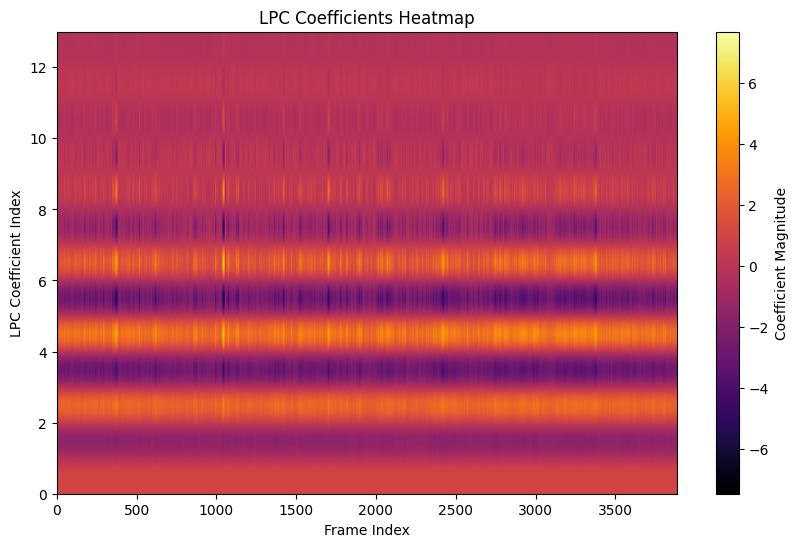

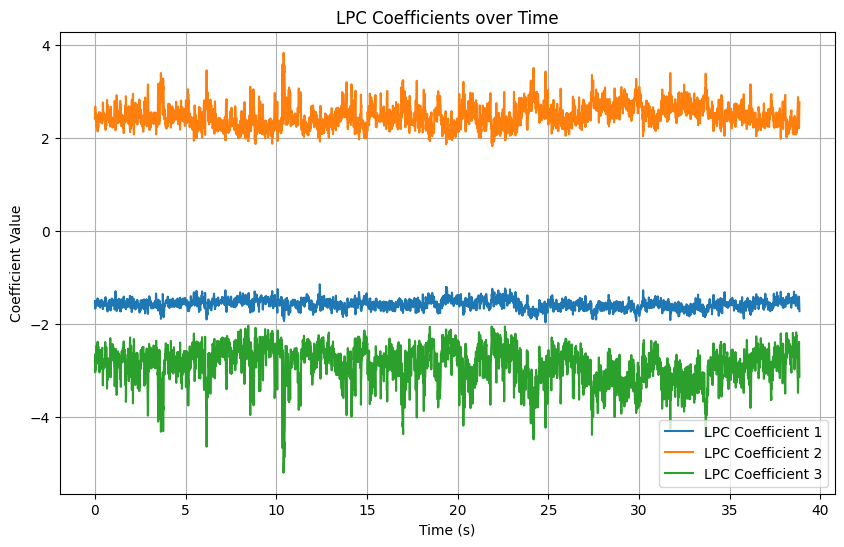

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Plot the audio signal (raw waveform)
plt.figure(figsize=(10, 4))
time = np.linspace(0, len(signal) / sampling_rate, num=len(signal))
plt.plot(time, signal)
plt.title("Raw Audio Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Step 2: Plot a heatmap of LPC coefficients across frames
plt.figure(figsize=(10, 6))
plt.imshow(lpc_coefficients.T, aspect='auto', origin='lower', cmap='inferno', extent=[0, len(frames), 0, lpc_order + 1])
plt.title("LPC Coefficients Heatmap")
plt.xlabel("Frame Index")
plt.ylabel("LPC Coefficient Index")
plt.colorbar(label="Coefficient Magnitude")
plt.show()

# Step 3: Plot individual LPC coefficients over time for selected coefficients (e.g., 1st, 2nd, and 3rd LPC coefficients)
plt.figure(figsize=(10, 6))
frame_times = np.arange(0, len(frames)) * (frame_step / sampling_rate)

# Plot a few specific LPC coefficients over time
plt.plot(frame_times, lpc_coefficients[:, 1], label="LPC Coefficient 1")
plt.plot(frame_times, lpc_coefficients[:, 2], label="LPC Coefficient 2")
plt.plot(frame_times, lpc_coefficients[:, 3], label="LPC Coefficient 3")

plt.title("LPC Coefficients over Time")
plt.xlabel("Time (s)")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid(True)
plt.show()


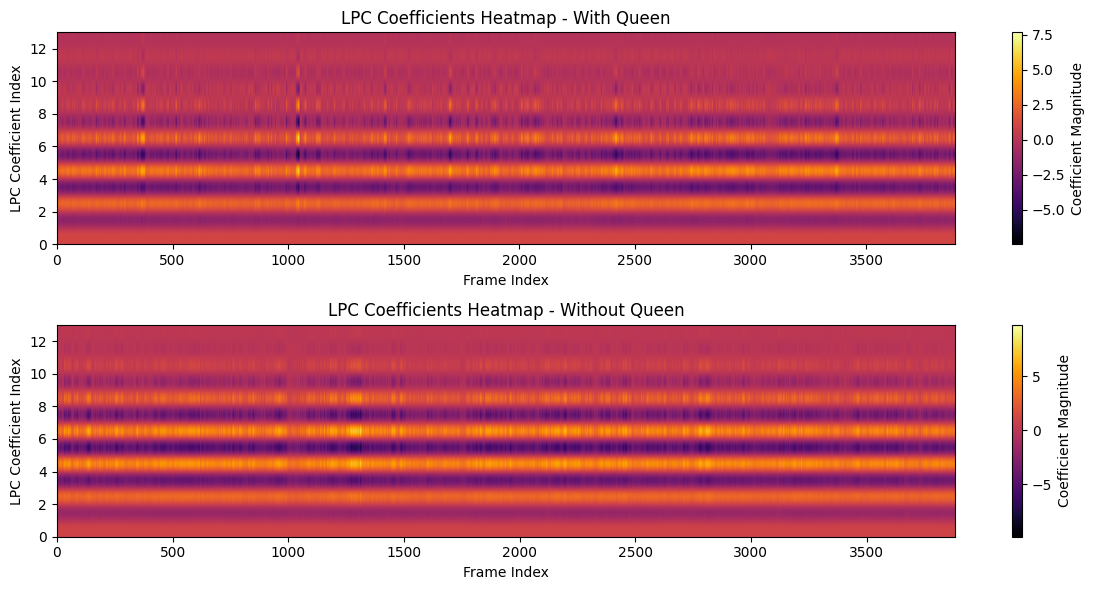

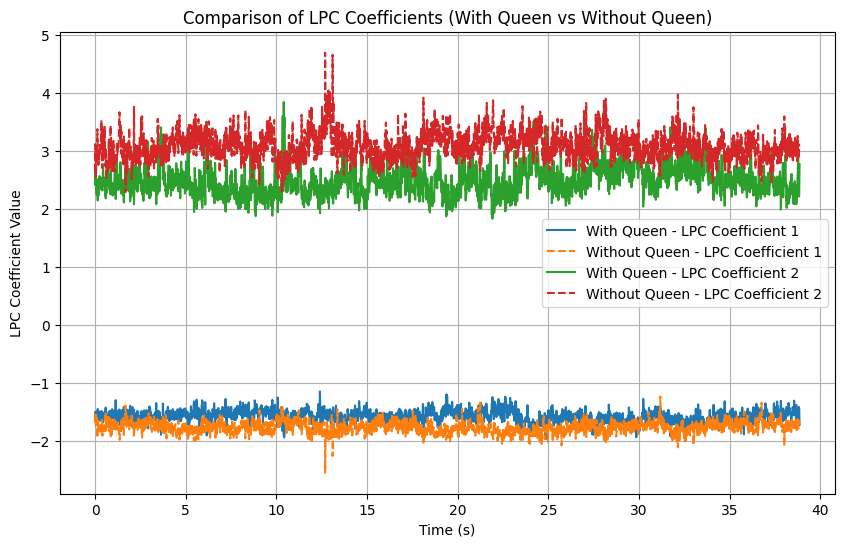

In [19]:
import os
import numpy as np
import scipy.io.wavfile as wav
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt

# Function to calculate LPC coefficients for a given audio signal
def calculate_lpc_coefficients(signal, sampling_rate, lpc_order=12, frame_size_ms=25, frame_step_ms=10):
    # Preprocess the signal (pre-emphasis)
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Convert frame size and step size from milliseconds to samples
    frame_size = int(frame_size_ms * sampling_rate / 1000)
    frame_step = int(frame_step_ms * sampling_rate / 1000)
    signal_length = len(emphasized_signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_size)) / frame_step))

    # Pad signal so that all frames have equal length
    pad_signal_length = num_frames * frame_step + frame_size
    z = np.zeros((pad_signal_length - signal_length))
    padded_signal = np.append(emphasized_signal, z)

    # Split signal into frames
    indices = np.tile(np.arange(0, frame_size), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_size, 1)).T
    frames = padded_signal[indices.astype(np.int32, copy=False)]

    # Apply Hamming window to each frame
    frames *= np.hamming(frame_size)

    # Function to compute autocorrelation
    def autocorrelation(signal, order):
        result = np.correlate(signal, signal, mode='full')
        return result[len(result)//2:len(result)//2 + order + 1]

    # Function to compute LPC coefficients
    def lpc(signal, order):
        R = autocorrelation(signal, order)
        R_matrix = solve_toeplitz((R[:-1], R[:-1]), R[1:])
        return np.concatenate(([1], -R_matrix))

    # Calculate LPC coefficients for each frame
    lpc_coefficients = []
    for frame in frames:
        coeffs = lpc(frame, lpc_order)
        lpc_coefficients.append(coeffs)
    
    return np.array(lpc_coefficients)

# Load the two audio files
Queen_wav_file_path = os.path.join(DATA_DIR, 'Bee-Sound-with-Queen.wav')
Without_Queen_file_path = os.path.join(DATA_DIR, 'Bee-Sound-without-Queen.wav')

sampling_rate_Queen, data_Queen = wav.read(Queen_wav_file_path)
sampling_rate_without_Queen, data_without_Queen = wav.read(Without_Queen_file_path)

# If stereo, convert to mono by averaging the channels
if data_Queen.ndim == 2:
    data_Queen = np.mean(data_Queen, axis=1)

if data_without_Queen.ndim == 2:
    data_without_Queen = np.mean(data_without_Queen, axis=1)

# Calculate LPC coefficients for both sets
lpc_order = 12
lpc_Queen = calculate_lpc_coefficients(data_Queen, sampling_rate_Queen, lpc_order)
lpc_without_Queen = calculate_lpc_coefficients(data_without_Queen, sampling_rate_without_Queen, lpc_order)

# Step 2: Visualize the LPC coefficients using heatmaps for both sets

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.imshow(lpc_Queen.T, aspect='auto', origin='lower', cmap='inferno', extent=[0, len(lpc_Queen), 0, lpc_order + 1])
plt.title("LPC Coefficients Heatmap - With Queen")
plt.xlabel("Frame Index")
plt.ylabel("LPC Coefficient Index")
plt.colorbar(label="Coefficient Magnitude")

plt.subplot(2, 1, 2)
plt.imshow(lpc_without_Queen.T, aspect='auto', origin='lower', cmap='inferno', extent=[0, len(lpc_without_Queen), 0, lpc_order + 1])
plt.title("LPC Coefficients Heatmap - Without Queen")
plt.xlabel("Frame Index")
plt.ylabel("LPC Coefficient Index")
plt.colorbar(label="Coefficient Magnitude")

plt.tight_layout()
plt.show()

# Step 3: Plot specific LPC coefficients (e.g., 1st, 2nd, 3rd) for comparison

plt.figure(figsize=(10, 6))
frame_times_Queen = np.arange(0, len(lpc_Queen)) * (0.01)  # 10ms step
frame_times_without_Queen = np.arange(0, len(lpc_without_Queen)) * (0.01)  # 10ms step

# Plot the 1st LPC coefficient for both
plt.plot(frame_times_Queen, lpc_Queen[:, 1], label="With Queen - LPC Coefficient 1")
plt.plot(frame_times_without_Queen, lpc_without_Queen[:, 1], label="Without Queen - LPC Coefficient 1", linestyle='dashed')

# Plot the 2nd LPC coefficient for both
plt.plot(frame_times_Queen, lpc_Queen[:, 2], label="With Queen - LPC Coefficient 2")
plt.plot(frame_times_without_Queen, lpc_without_Queen[:, 2], label="Without Queen - LPC Coefficient 2", linestyle='dashed')

plt.title("Comparison of LPC Coefficients (With Queen vs Without Queen)")
plt.xlabel("Time (s)")
plt.ylabel("LPC Coefficient Value")
plt.legend()
plt.grid(True)
plt.show()


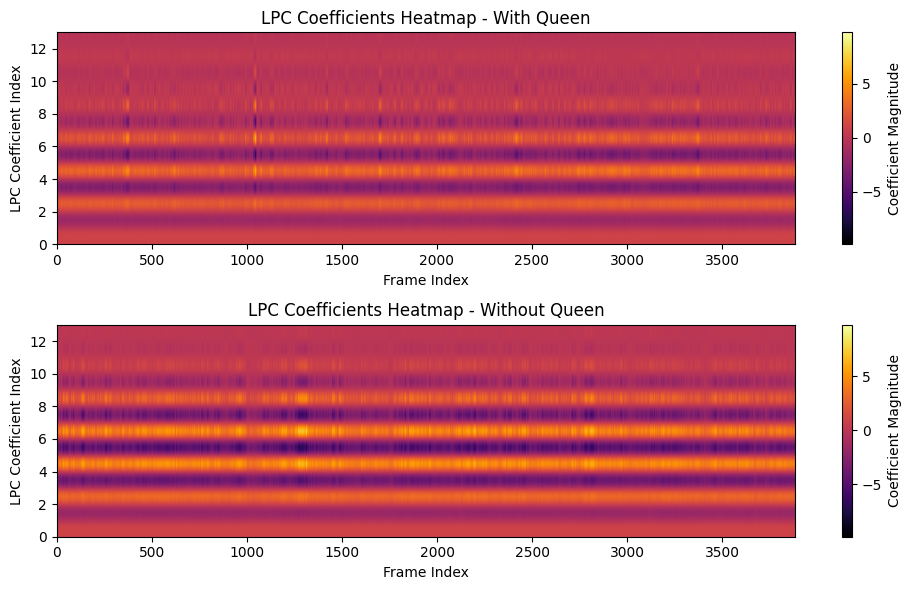

In [22]:
min_val = min(np.min(lpc_Queen), np.min(lpc_without_Queen))
max_val = max(np.max(lpc_Queen), np.max(lpc_without_Queen))
plt.figure(figsize=(10, 6))

# Heatmap for "With Queen"
plt.subplot(2, 1, 1)
plt.imshow(lpc_Queen.T, aspect='auto', origin='lower', cmap='inferno', extent=[0, len(lpc_Queen), 0, lpc_order + 1], vmin=min_val, vmax=max_val)
plt.title("LPC Coefficients Heatmap - With Queen")
plt.xlabel("Frame Index")
plt.ylabel("LPC Coefficient Index")
plt.colorbar(label="Coefficient Magnitude")

# Heatmap for "Without Queen"
plt.subplot(2, 1, 2)
plt.imshow(lpc_without_Queen.T, aspect='auto', origin='lower', cmap='inferno', extent=[0, len(lpc_without_Queen), 0, lpc_order + 1], vmin=min_val, vmax=max_val)
plt.title("LPC Coefficients Heatmap - Without Queen")
plt.xlabel("Frame Index")
plt.ylabel("LPC Coefficient Index")
plt.colorbar(label="Coefficient Magnitude")

# Save heatmap plot
plt.tight_layout()
plt.savefig('LPC_Heatmap_Comparison.png', dpi=300)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (12,) and (13,)

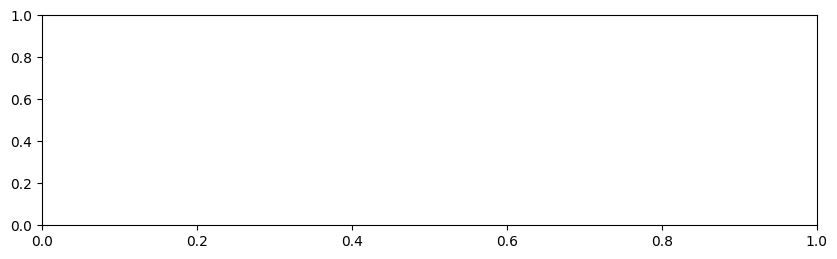

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean and variance of LPC coefficients across all frames
mean_lpc_Queen = np.mean(lpc_Queen, axis=0)
mean_lpc_without_Queen = np.mean(lpc_without_Queen, axis=0)
var_lpc_Queen = np.var(lpc_Queen, axis=0)
var_lpc_without_Queen = np.var(lpc_without_Queen, axis=0)

# Number of LPC coefficients (including intercept term)
coeff_indices = np.arange(1, lpc_order + 2)  # Should be 13 points (for 12th-order LPC)

# Plot mean LPC coefficients
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(coeff_indices, mean_lpc_Queen, label="With Queen - Mean", marker='o')
plt.plot(coeff_indices, mean_lpc_without_Queen, label="Without Queen - Mean", marker='o', linestyle='dashed')
plt.title("Mean of LPC Coefficients (With Queen vs Without Queen)")
plt.xlabel("LPC Coefficient Index")
plt.ylabel("Mean LPC Coefficient Value")
plt.legend()
plt.grid(True)

# Plot variance of LPC coefficients
plt.subplot(2, 1, 2)
plt.plot(coeff_indices, var_lpc_Queen, label="With Queen - Variance", marker='o')
plt.plot(coeff_indices, var_lpc_without_Queen, label="Without Queen - Variance", marker='o', linestyle='dashed')
plt.title("Variance of LPC Coefficients (With Queen vs Without Queen)")
plt.xlabel("LPC Coefficient Index")
plt.ylabel("Variance of LPC Coefficient Value")
plt.legend()
plt.grid(True)

# Save plot
plt.tight_layout()
plt.savefig('LPC_Coefficient_Mean_Variance_Comparison.png', dpi=300)
plt.show()
